## Question 1

In [2]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import sympy as sp

In [3]:
df = pd.read_csv("Kinetics.csv")
S1 = df["S1"].to_numpy(dtype=float)
S2 = df["S2"].to_numpy(dtype=float)
vlt = df["Rate"].to_numpy(dtype=float)

# assume constant sigma for chi-square scaling
sigma = np.full_like(vlt, fill_value = np.std(vlt)*0.02)
sigma = np.where(sigma <= 0, 1.0, sigma)

In [4]:
def pingpong_bibi(params, s1, s2):
    """ 
    v = Vmax * s1 * s2 / (Km2 * s1 + Km1 * s2 + s1 * s2)
    params = [Vmax, Km1, Km2]
    """
    Vmax, Km1, Km2 = params
    num = Vmax * s1 * s2 
    den = Km2 * s1 + Km1 * s2 + s1 * s2
    return num / den

def sequential_type1a(params, s1, s2):
    """
    v = Vmax * s1 * s2 / (Kis1 * Km1 + Km1 * s1 + s1 * s2)
    params = [Vmax, Km1, Kis1]
    """
    Vmax, Km1, Kis1 = params
    num = Vmax * s1 * s2
    den = Kis1 * Km1 + Km1 * s1 + s1 * s2
    return num / den

def sequential_type1b(params, s1, s2):
    """
    v = Vmax * s1 * s2 / (Kis1 * Km1 + Km1 * s1 + Km2 * s2 + s1 * s2)
    params = [Vmax, Km1, Km2, Kis1]
    """
    Vmax, Km1, Km2, Kis1 = params
    num = Vmax * s1 * s2
    den = Kis1 * Km1 + Km1 * s1 + Km2 * s2 + s1 * s2
    return num / den

In [5]:
@dataclass
class FitResult:
    name: str
    params: np.ndarray
    success: bool
    r2: float
    chi2: float
    red_chi2: float

In [6]:
def r2_score(y, yhat):
    ss_res = np.sum((y-yhat)**2)
    ss_tot = np.sum((y-np.mean(y)) ** 2)
    return 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

def fit_model(model_fun, name, p0, bounds, s1, s2, v, sigma):
    """
    Weighted least squares fit using least_squares.
    Minimize sum(((v-model)/sigma)^2).
    """
    def residuals(p):
        return (v-model_fun(p,s1,s2))/sigma
    
    res = least_squares(residuals, x0=np.array(p0, dtype=float), bounds=bounds, method="trf")
    p_hat = res.x
    v_hat = model_fun(p_hat, s1, s2)

    chi2 = np.sum(((v-v_hat)/sigma)**2)
    dof = max(len(v) - len(p_hat), 1)
    red_chi2 = chi2 / dof 
    r2 = r2_score(v, v_hat)

    return FitResult(
        name = name,
        params = p_hat,
        success = res.success,
        r2 = r2,
        chi2 = chi2,
        red_chi2 = red_chi2,
    )

In [7]:
# Initial guess
Vmax0 = np.max(vlt)
Km10 = np.median(S1)
Km20 = np.median(S2)
Kis10 = Km10

# Enforce positivity for kinetic constants
pos_low = 1e-12

fits = []

# Ping-pong
fits.append(
    fit_model(
        pingpong_bibi,
        "PingPong",
        p0 = [Vmax0, Km10, Km20],
        bounds = ([pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf]),
        s1 = S1, s2 = S2, v = vlt, sigma = sigma
    )
)

# Sequantial type 1a
fits.append(
    fit_model(
        sequential_type1a,
        "Sequential type 1a",
        p0 = [Vmax0, Km10, Kis10],
        bounds = ([pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf]),
        s1 = S1, s2 = S2, v = vlt, sigma = sigma
    )
)

# Sequential type 1b 
fits.append(
    fit_model(
        sequential_type1b,
        "Sequential type 1b",
        p0 = [Vmax0, Km10, Km20, Kis10],
        bounds = ([pos_low, pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf, np.inf]),
        s1 = S1, s2 = S2, v = vlt, sigma = sigma
    )
)

# Print comparison
fits_sorted = sorted(fits, key = lambda fr: fr.red_chi2)
for fr in fits_sorted:
    print(f"\n==={fr.name}===")
    print("success  :", fr.success)
    print("params   :", fr.params)
    print("R^2      :", fr.r2)
    print("chi^2    :", fr.chi2)
    print("red chi^2:", fr.red_chi2)

best = fits_sorted[0]
print("\nBest by reduced chi-square:", best.name)


===PingPong===
success  : True
params   : [1.  0.1 0.1]
R^2      : 1.0
chi^2    : 1.2435069832463078e-25
red chi^2: 4.186892199482518e-28

===Sequential type 1b===
success  : True
params   : [9.99999990e-01 9.99999944e-02 9.99999942e-02 2.05561549e-08]
R^2      : 0.9999999999999994
chi^2    : 4.5459515716978655e-10
red chi^2: 1.5357944498979276e-12

===Sequential type 1a===
success  : True
params   : [0.78808214 0.03331481 0.59980728]
R^2      : 0.8095529965199977
chi^2    : 142835.25261000168
red chi^2: 480.9267764646521

Best by reduced chi-square: PingPong


Both ping-pong and sequential-random can fit the dataset nearly perfectly. However, the sequential-random fit collapses with Kis1≈0, indicating the extra term is not supported (parameter degeneracy).

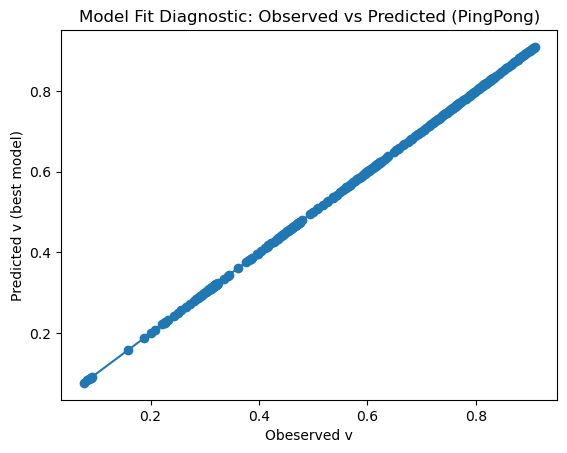

In [68]:
model_map = {
    "PingPong": pingpong_bibi,
    "Sequential type 1a": sequential_type1a,
    "Sequential type 1b": sequential_type1b,
}

best_fun = model_map[best.name]
v_best = best_fun(best.params, S1, S2)

plt.figure()
plt.scatter(vlt, v_best)
mn,mx = min(vlt.min(), v_best.min()), max(vlt.max(), v_best.max())
plt.plot([mn,mx],[mn,mx])
plt.xlabel("Obeserved v")
plt.ylabel("Predicted v (best model)")
plt.title(f"Model Fit Diagnostic: Observed vs Predicted ({best.name})")
plt.show()

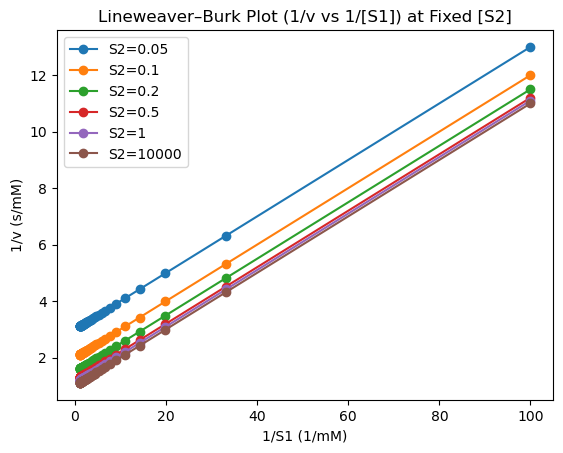

In [69]:
for s2_val, sub in df.groupby("S2"):
    sub = sub.sort_values("S1")
    x = 1.0 / sub["S1"].to_numpy()
    y = 1.0 / sub["Rate"].to_numpy()
    plt.plot(x, y, marker = "o", linestyle = "-", label = f"S2={s2_val:g}")

plt.xlabel("1/S1 (1/mM)")
plt.ylabel("1/v (s/mM)")
plt.title("Lineweaver–Burk Plot (1/v vs 1/[S1]) at Fixed [S2]")
plt.legend()
plt.show()

In [19]:
# Stochastic results: bootstrap parameter distributions
def bootstrap_fit(model_fun, name, p0, bounds, s1, s2, v, sigma, B =1000, seed = 0):
    """
    Nonparametric bootstrap: resample rows with replacement, refit each time.
    Returns array of shape (B, n_params).
    """
    rng = np.random.default_rng(seed)
    n = len(v)
    n_params = len(p0)
    samples = np.zeros((B,n_params), dtype=float)
    ok = np.zeros(B, dtype=bool)
    for b in range(B):
        idx = rng.integers(0, n, size = n)
        s1b, s2b, vb, sigb = s1[idx], s2[idx], v[idx], sigma[idx]

        fr = fit_model(model_fun, name, p0, bounds, s1b, s2b, vb, sigb)
        samples[b,:] = fr.params
        ok[b] = fr.success
    
    return samples, ok

if best.name == "PingPong":
    p0_best = [Vmax0, Km10, Km20]
    bounds_best = ([pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf])
elif best.name == "Sequential type 1a":
    p0_best = [Vmax0, Km10, Kis10]
    bounds_best = ([pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf])
else:
    p0_best = [Vmax0, Km10, Km20, Kis10]
    bounds_best = ([pos_low, pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf, np.inf])

samples, ok = bootstrap_fit(best_fun, best.name, p0_best, bounds_best, S1, S2, vlt, sigma, B=1000, seed=42)
samples_ok = samples[ok]

print(f"\nBootstrap success rate: {ok.mean():.3f} (kept {samples_ok.shape[0]} fits)")

# Summaries (95% CI)
param_names = {
    "PingPong": ["Vmax", "Km1", "Km2"],
    "Sequential type 1a": ["Vmax", "Km1", "Kis1"],
    "Sequential type 1b": ["Vmax", "Km1", "Km2", "Kis1"],
}[best.name]

for j, nm in enumerate(param_names):
    vals = samples_ok[:, j]
    lo, med, hi = np.percentile(vals, [2.5, 50, 97.5])
    print(f"{nm:>5s}: median={med:.6g}, 95% CI=({lo:.6g}, {hi:.6g})")



Bootstrap success rate: 1.000 (kept 1000 fits)
 Vmax: median=1, 95% CI=(1, 1)
  Km1: median=0.1, 95% CI=(0.1, 0.1)
  Km2: median=0.1, 95% CI=(0.1, 0.1)


In [11]:
MW = 150.0  # g/mol
S0_gL = 100.0
Sf_gL = 1.0

Vmax = 1.0  # mM/s
Km = 0.1    # mM

# Convert g/L -> mM
S0_mM = (S0_gL / MW) * 1000.0
Sf_mM = (Sf_gL / MW) * 1000.0

# Integrated Michaelis–Menten batch time:
# t = (S0 - Sf)/Vmax + (Km/Vmax)*ln(S0/Sf)
t_sec = (S0_mM - Sf_mM) / Vmax + (Km / Vmax) * np.log(S0_mM / Sf_mM)

print("S0 (mM):", S0_mM)
print("Sf (mM):", Sf_mM)
print("Time (s):", t_sec)
print("Time (min):", t_sec / 60.0)


S0 (mM): 666.6666666666666
Sf (mM): 6.666666666666667
Time (s): 660.4605170185988
Time (min): 11.007675283643314


## Question 2 

## b.

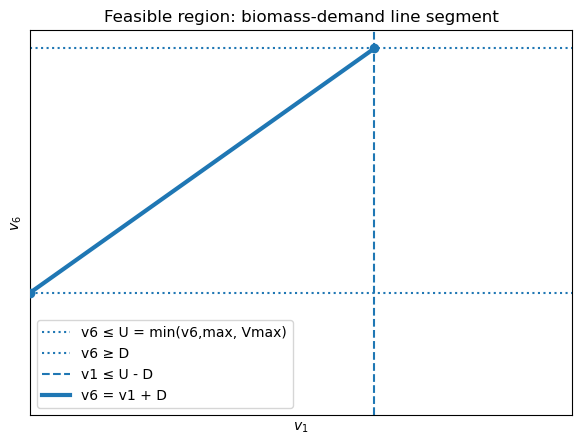

In [ ]:
# arbitrary values to make plot
v6_max = 5.0   # v_{6,max}
Vmax   = 3.0   # V_max from MM kinetics (cap on v6)
D      = 1.0   # biomass demand v9 = D
U = min(v6_max, Vmax)

v1 = np.linspace(0, U-D, 400)

plt.figure(figsize=(7, 5))

# Boundary lines
plt.axhline(U,      linestyle=":",  label="v6 ≤ U = min(v6,max, Vmax)")
plt.axhline(D,      linestyle=":",  label="v6 ≥ D")
if D <= U:
    v1_max = U - D
    plt.axvline(v1_max, linestyle="--", label=f"v1 ≤ U - D")


v1_line = np.linspace(0, U, 400)
v6_line = v1_line + D

ok = (v1_line >= 0) & (v1_line <= U-D) & (v6_line <= U) & (v6_line >= D)

if np.any(ok):
    plt.plot(v1_line[ok], v6_line[ok], linewidth=3, label="v6 = v1 + D")
    v1_lo, v1_hi = v1_line[ok][0], v1_line[ok][-1]
    plt.scatter([v1_lo, v1_hi], [v1_lo + D, v1_hi + D], zorder=5)
    plt.title("Feasible region: biomass-demand line segment")


plt.xlim(0, U * 1.05 if U > 0 else 1)
plt.ylim(0, U * 1.05 if U > 0 else max(D, 1) * 1.05)
plt.xlabel(r"$v_1$")
plt.ylabel(r"$v_6$")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks([])
plt.yticks([])
plt.show()



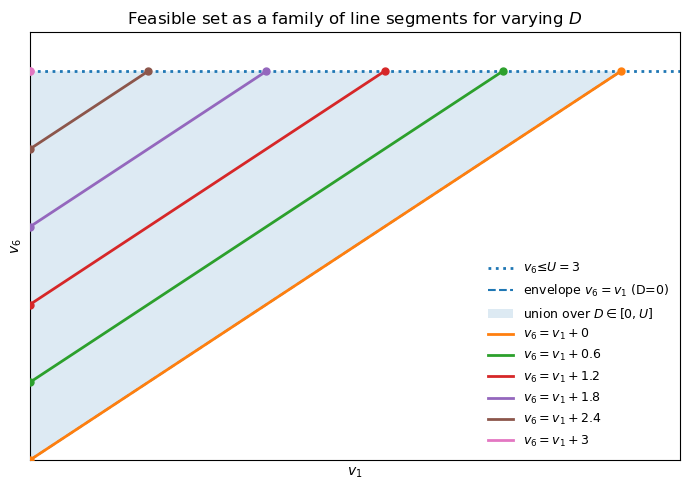

In [75]:
# fixed caps
v6_max = 5.0
Vmax   = 3.0
U = min(v6_max, Vmax)

# choose the D range you want to visualize (you decide this)
D_min = 0.0
D_max = U   # anything > U has no feasible segment
D_values = np.linspace(D_min, D_max, 6)   # 6 example segments

plt.figure(figsize=(7, 5))

# --- fixed boundary: v6 <= U
plt.axhline(U, linestyle=":", linewidth=2, label=rf"$v_6 ≤ U={U:g}$")

# --- optional: show the diagonal boundary v6 >= v1 (this is the union envelope when D>=0)
v1_env = np.linspace(0, U, 400)
plt.plot(v1_env, v1_env, linestyle="--", linewidth=1.5, label=r"envelope $v_6=v_1$ (D=0)")

# --- (OPTIONAL) shade the UNION region for D in [D_min, D_max]
# union for D in [D_min, D_max] is:
#   v6 between v1 + D_min and min(U, v1 + D_max), with v1 in [0, U - D_min]
v1_union = np.linspace(0, max(U - D_min, 0), 400)
lower = v1_union + D_min
upper = np.minimum(U, v1_union + D_max)
ok_union = upper >= lower
plt.fill_between(v1_union[ok_union], lower[ok_union], upper[ok_union],
                 alpha=0.15, label=rf"union over $D\in[{D_min:g},U]$")

# --- plot the FAMILY of segments (each D gives one segment)
for D in D_values:
    if D > U:
        continue  # no feasible points
    v1 = np.linspace(0, U - D, 300)
    v6 = v1 + D
    plt.plot(v1, v6, linewidth=2, label=rf"$v_6=v_1+{D:g}$")
    # endpoints
    plt.scatter([0, U - D], [D, U], s=25, zorder=5)

plt.title("Feasible set as a family of line segments for varying $D$")
plt.xlim(0, U * 1.1 if U > 0 else 1)
plt.ylim(0, U * 1.1 if U > 0 else 1)
plt.xlabel(r"$v_1$")
plt.ylabel(r"$v_6$")
plt.grid(True, alpha=0.3)

# keep legend readable
plt.legend(frameon=False, fontsize=9, ncols=1, loc="lower right")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()


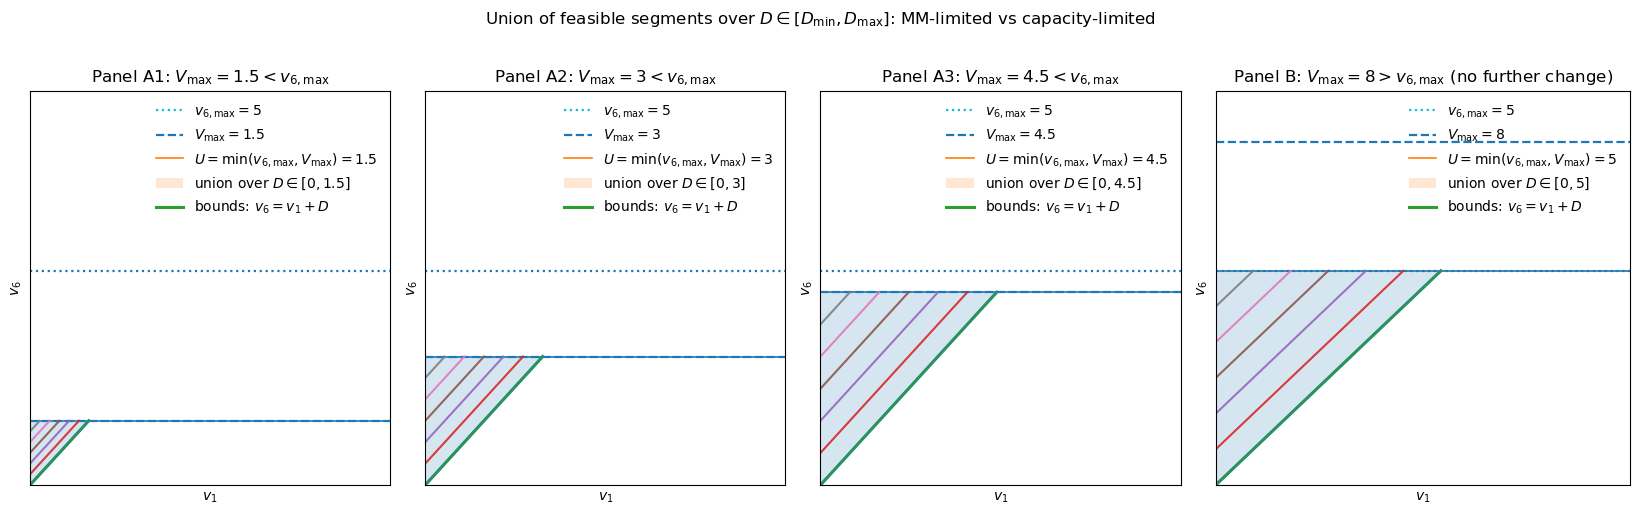

In [92]:
def plot_union_over_D_with_multiple_Vmax(
    v6_max,
    Vmax_list_small,     # list of Vmax values all < v6_max (Panel A)
    Vmax_big,            # one value > v6_max (Panel B)
    D_min,
    D_max,
    n_segments=7,
    n=300,
):
    """
    Panel A: multiple subplots, each with a different Vmax < v6_max (MM-limited),
             to show how increasing Vmax expands the union region.

    Panel B: one subplot with Vmax > v6_max (capacity-limited),
             to show that Vmax no longer changes the region once capped by v6_max.

    For each fixed U = min(v6_max, Vmax), and D in [D_min, D_max], union region is a band:
      v6 = v1 + D,  0 <= v1 <= U - D  (feasible iff D <= U)
    """

    def clip_D_range(U, Dmin, Dmax):
        lo = max(0.0, float(Dmin))
        hi = min(float(Dmax), float(U))
        if lo > hi:
            return None
        return lo, hi

    def band_polygon(U, Dmin, Dmax):
        clipped = clip_D_range(U, Dmin, Dmax)
        if clipped is None:
            return None
        d1, d2 = clipped

        x2 = U - d2   # where v6=v1+d2 hits v6=U
        x1 = U - d1   # where v6=v1+d1 hits v6=U

        pts = [
            (0.0, d1),
            (0.0, d2),
            (x2,  U),
            (x1,  U),
            (0.0, d1),
        ]
        xs = np.array([p[0] for p in pts])
        ys = np.array([p[1] for p in pts])
        return xs, ys, (d1, d2)

    def plot_example_segments(ax, U, d1, d2, k=n_segments):
        if k <= 1:
            Ds = np.array([0.5*(d1+d2)])
        else:
            Ds = np.linspace(d1, d2, k)
        for D in Ds:
            if D > U:
                continue
            v1 = np.linspace(0, U - D, n)
            v6 = v1 + D
            ax.plot(v1, v6, linewidth=1.5, alpha=0.9)

    def draw_one(ax, Vmax_val, title=None, show_legend=True):
        U = min(v6_max, Vmax_val)
        if title is None:
            title = rf"$V_{{\max}}={Vmax_val:g}$,  $U={U:g}$"

        ax.set_title(title)

        # caps
        ax.axhline(v6_max, linestyle=":",  linewidth=1.6)
        ax.axhline(Vmax_val, linestyle="--", linewidth=1.6)
        ax.axhline(U, linestyle="-", linewidth=1.2)

        poly = band_polygon(U, D_min, D_max)
        if poly is None:
            ax.text(0.05, 0.9, r"No feasible set", transform=ax.transAxes)
        else:
            xs, ys, (d1, d2) = poly

            # union band
            ax.fill(xs, ys, alpha=0.18)

            # boundaries
            v1_lo = np.linspace(0, U - d1, n)
            ax.plot(v1_lo, v1_lo + d1, linewidth=2.2)

            v1_hi = np.linspace(0, U - d2, n)
            ax.plot(v1_hi, v1_hi + d2, linewidth=2.2)

            # example segments
            plot_example_segments(ax, U, d1, d2, k=n_segments)

            if show_legend:
                ax.plot([], [], linestyle=":",  linewidth=1.6, label=rf"$v_{{6,\max}}={v6_max:g}$")
                ax.plot([], [], linestyle="--", linewidth=1.6, label=rf"$V_{{\max}}={Vmax_val:g}$")
                ax.plot([], [], linestyle="-",  linewidth=1.2, label=rf"$U=\min(v_{{6,\max}},V_{{\max}})={U:g}$")
                ax.fill([], [], alpha=0.18, label=rf"union over $D\in[{max(0,D_min):g},{min(D_max,U):g}]$")
                ax.plot([], [], linewidth=2.2, label=rf"bounds: $v_6=v_1+D$")

        ax.set_xlabel(r"$v_1$")
        ax.set_ylabel(r"$v_6$")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True, alpha=0.25)

        if show_legend:
            ax.legend(frameon=False, loc="upper right")

        return U

    Vmax_list_small = list(Vmax_list_small)
    m = len(Vmax_list_small)

    fig = plt.figure(figsize=(4*m + 4.5, 5))
    gs = fig.add_gridspec(1, m + 1, width_ratios=[1]*m + [1.15])


    axesA = [fig.add_subplot(gs[0, i]) for i in range(m)]
    U_list = []
    for i, V in enumerate(Vmax_list_small):
        U_i = draw_one(
            axesA[i],
            V,
            title=rf"Panel A{i+1}: $V_{{\max}}={V:g}<v_{{6,\max}}$",
            show_legend= True  # legend only once to reduce clutter
        )
        U_list.append(U_i)

    # Panel B: capacity-limited (one Vmax > v6_max)
    axB = fig.add_subplot(gs[0, m])
    U_B = draw_one(
        axB,
        Vmax_big,
        title=rf"Panel B: $V_{{\max}}={Vmax_big:g}>v_{{6,\max}}$ (no further change)",
        show_legend=True
    )

    # --------- Make axes comparable (so "expansion" is obvious)
    # Use a common ymax across all panels
    U_max = max(U_list + [U_B, v6_max, Vmax_big, D_max, 1.0])
    for ax in axesA + [axB]:
        ax.set_xlim(0, U_max * 1.15)
        ax.set_ylim(0, U_max * 1.15)

    fig.suptitle(r"Union of feasible segments over $D\in[D_{\min},D_{\max}]$: MM-limited vs capacity-limited", y=1.02)
    fig.tight_layout()
    plt.show()


v6_max = 5.0
Vmax_list_small = [1.5, 3, 4.5]  # all < v6_max, so U=Vmax and band expands
Vmax_big = 8.0                          # > v6_max, so U=v6_max and stops changing
D_min = 0.0
D_max = 5.0

plot_union_over_D_with_multiple_Vmax(
    v6_max=v6_max,
    Vmax_list_small=Vmax_list_small,
    Vmax_big=Vmax_big,
    D_min=D_min,
    D_max=D_max,
    n_segments=7
)


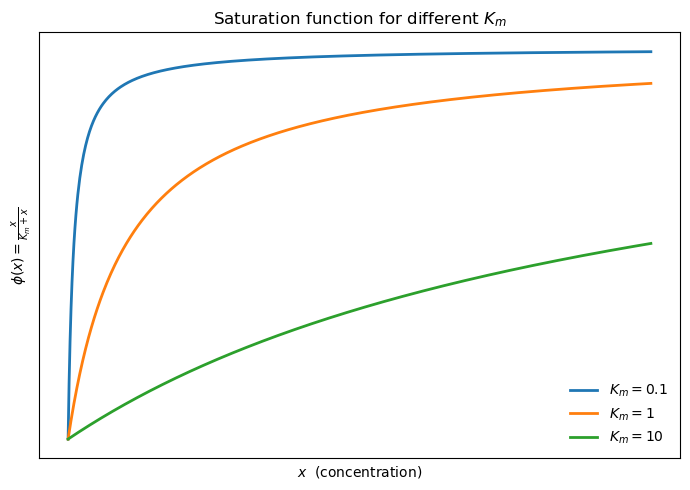

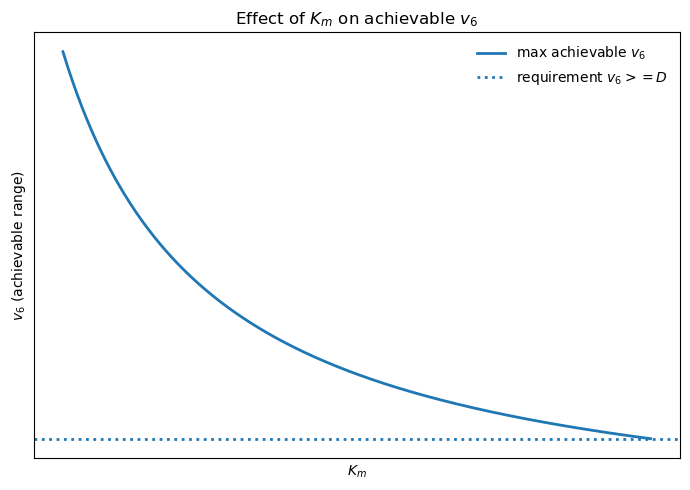

In [72]:
def plot_km_saturation_curves(Km_list, x_max=10.0, n=600):
    x = np.linspace(0.0, x_max, n)

    plt.figure(figsize=(7, 5))
    for Km in Km_list:
        phi = x / (Km + x)
        plt.plot(x, phi, linewidth=2, label=rf"$K_m={Km:g}$")

    plt.xlabel(r"$x$  (concentration)")
    plt.ylabel(r"$\phi(x)=\frac{x}{K_m+x}$")
    plt.title(r"Saturation function for different $K_m$")
    plt.grid(True, alpha=0.25)
    plt.xticks([])
    plt.yticks([])
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


def plot_km_effect_on_v6(Vmax, D, SUC_max, FUM_max, Km_grid):
    Km_grid = np.asarray(Km_grid, dtype=float)

    term_suc = SUC_max / (Km_grid + SUC_max)
    term_fum = FUM_max / (Km_grid + FUM_max)
    v6_max_ach = Vmax * (term_suc - 0.0)

    plt.figure(figsize=(7, 5))
    plt.plot(Km_grid, v6_max_ach, linewidth=2, label=r"max achievable $v_6$")
    plt.axhline(D, linestyle=":", linewidth=2, label=r"requirement $v_6 >= D$")

    plt.xlabel(r"$K_m$")
    plt.ylabel(r"$v_6$ (achievable range)")
    plt.title(r"Effect of $K_m$ on achievable $v_6$")
    plt.grid(True, alpha=0.25)
    plt.xticks([])
    plt.yticks([])
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


Km_list_for_phi = [0.1, 1.0, 10.0]
plot_km_saturation_curves(Km_list_for_phi, x_max=10.0)

Vmax = 5.0
D = 1.0
SUC_max = 5.0
FUM_max = 5.0
Km_grid = np.linspace(0.01, 20.0, 500)

plot_km_effect_on_v6(Vmax=Vmax, D=D, SUC_max=SUC_max, FUM_max=FUM_max, Km_grid=Km_grid)

